<a href="https://colab.research.google.com/github/cqschlortt/Steane-s-Code-with-Pauli-Error-Channel/blob/main/Steane's_Code_for_Error_Correction_under_Random_Pauli_Error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Steane's Code for Error Correction under Random Pauli Error
This is a function that takes the following inputs:
1.   A Boolean, $x ∈ F^2_n$
2.   An error probability $p$.

The ouput of the function is a quantum circuit that prepares (not neceassarily fault tolerantly) the logical $|x_L〉$ state
in Steane’s code, runs it through a Pauli error channel, with error rate p (for each qubits), measures syndromes,
applies the recovery operations (if needed), measures the data qubits, and decodes the result.
The success probabilty, is the probabilty that you measure a component of the logical all-zero state at the end.
Visualize the dependence of the success probability for various values of $p$.

###Preliminaries (install needed packages)

In [1]:
%pip install qiskit numpy
%pip install pylatexenc
%pip install qiskit_aer
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt
from itertools import permutations

from qiskit_aer import AerSimulator, Aer
from qiskit.compiler import transpile

import numpy as np
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 623.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=0ec6fb87970f8620790cbb11ac95b8ffd0299a8ae728b57525a674542d3bfd26
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.6 MB/s eta 0:00:00


##Steane's Code and Pauli Error Channel Function
###steane_code_error_correction

Parameters: p is the error probability and boolean_input is the original boolean number on which the code will be run

Objective: Prepare a circuit which encodes the given boolean of size n into n quantum registers of size 7 (one register per each logical bit), run the given circuit through a random Pauli error channel, measure the syndroms, and error correct if needed.



This code can be looked at in four distinct parts (as marked in the code below):

Encoding the bits with the Steane's Code: For each Boolean bit involved, the bit is encoded into 7 cubits using a combination of Hadamard and CNOT gates:

\begin{align*}
|0_L> &= \frac{1}{\sqrt{8}}(|0000000>+|0101010>+|0110011>+|0001111>+|1011010>+|01111000>+|1101001>)\\
|1_L> &= \frac{1}{\sqrt{8}}(|1111111>+|0101010>+|1001100>+|1001100>+|0011001>+|1110000>+|0100101>+|1000011>+|0010110>)
\end{align*}

Pauli Errors: A Pauli error is introduced at random by selecting a random number "r" between 0 and 1, if the number is smaller than $\frac{1}{3}$ an X error is applies, if $\frac{1}{3}\leq r<\frac{2}{3}$ a Y error is applied, and if $\frac{2}{3} <r$, a Z error is introduced.

Steane Code: Measurements and Corrections: Establish the list of X and Z stabalizers (ie IIIXXXX, IXXIIXX, XIXIXIX, IIIZZZ, IZZIIZZ, ZIZIZIZ) by listing the indices on which the X or Z gate will be applied.  First check for bit flip errors by applying the X stabalizers to the 7 qubits which represent each of the logical bits (this is accompliched by using CNOT gates for which the specified stabilizer indices are the controls and the target is the ancilla which represents that stabalizer, then measuring into a three bit classical register).  Then check for phase flip errors by applying the Z stabalizers to the 7 qubits which represent each of the logical bits (this is accomplished by applying Hadamard Gates to the ancillas, then using CNOT gates for which the control is the ancilla and the target is the specified indices, then applying another Hadamard gate to the ancillas, which is equivelent to a controlled Z gate, then the ancillas are measured into a three bit classical register).  Finally, these syndrome measurements are used to correct potential errors in each of the 7 qubits which represent a single logical qubit by matching the following errors:

For the bit flip detection:
\begin{align}
    \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}   &\mapsto X_0 \\
    \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}   &\mapsto X_1 \\
    \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}   &\mapsto X_2 \\
    \begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}   &\mapsto X_3 \\
    \begin{pmatrix} 0 \\ 1 \\ 1 \end{pmatrix}   &\mapsto X_4 \\
    \begin{pmatrix} 1 \\ 0 \\ 1 \end{pmatrix}   &\mapsto X_5 \\
    \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}   &\mapsto X_6 \\
\end{align}

and for the phase flip detection

\begin{align}
    \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}   &\mapsto Z_0 \\
    \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}   &\mapsto Z_1 \\
    \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}   &\mapsto Z_2 \\
    \begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}   &\mapsto Z_3 \\
    \begin{pmatrix} 0 \\ 1 \\ 1 \end{pmatrix}   &\mapsto Z_4 \\
    \begin{pmatrix} 1 \\ 0 \\ 1 \end{pmatrix}   &\mapsto Z_5 \\
    \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}   &\mapsto Z_6 \\
\end{align}

If an error is detected in the classical register, the error is corrected by applying an x gate (for X errors) or a z gate (for Z errors) to the appropriate qubit.

Final Measurement: The final measurement creates size 7 classical registers for each logical bit and measures the final values of the 7*n classical registers representing the logical boolean into these registers.

In [2]:
def steane_code_error_correction(p, boolean_input):
 n = len(boolean_input)

 #-------------Encoding the bits with the Steane's code--------------------------
 quantum_register_x = {}
 for i in range(n):
  quantum_register_x[f'x_{i}'] = QuantumRegister(size=7, name=f'x_{i}')

 all_quantum_registers = list(quantum_register_x.values())
 # Add ancilla and classical registers to the circuit definition
 an = AncillaRegister(3, 'an')
 bit_flip = {}
 phase_flip = {}
 for i in range(n):
    bit_flip[f'x_{i}'] = ClassicalRegister(3, f'bit_flip_{i}')
    phase_flip[f'x_{i}'] = ClassicalRegister(3, f'phase_flip_{i}')

 all_classical_registers = list(bit_flip.values()) + list(phase_flip.values())
 qc = QuantumCircuit(*all_quantum_registers, an, *all_classical_registers)

 for i in range(n):
  if boolean_input[i]==1:
     for j in range(7):
        qc.x(quantum_register_x[f'x_{i}'][j])
  # –-----------------Entanglement
  qc.h(quantum_register_x[f'x_{i}'][0])
  qc.h(quantum_register_x[f'x_{i}'][1])
  qc.h(quantum_register_x[f'x_{i}'][2])

  qc.cx(quantum_register_x[f'x_{i}'][0], quantum_register_x[f'x_{i}'][2])
  qc.cx(quantum_register_x[f'x_{i}'][3], quantum_register_x[f'x_{i}'][5])
  qc.cx(quantum_register_x[f'x_{i}'][1], quantum_register_x[f'x_{i}'][6])

  qc.cx(quantum_register_x[f'x_{i}'][0], quantum_register_x[f'x_{i}'][4])
  qc.cx(quantum_register_x[f'x_{i}'][3], quantum_register_x[f'x_{i}'][6])
  qc.cx(quantum_register_x[f'x_{i}'][1], quantum_register_x[f'x_{i}'][5])

  qc.cx(quantum_register_x[f'x_{i}'][0], quantum_register_x[f'x_{i}'][6])
  qc.cx(quantum_register_x[f'x_{i}'][3], quantum_register_x[f'x_{i}'][4])
  qc.cx(quantum_register_x[f'x_{i}'][1], quantum_register_x[f'x_{i}'][2])

#-------------------------------------------------------------------------------
#-------------Pauli Errors------------------------------------------------------
 for i in range(n):
  r=random.random()
  if r < p:
   qc.x(quantum_register_x[f'x_{i}']) #Add an X error
  elif r < 2*p:
   qc.y(quantum_register_x[f'x_{i}']) #Add a Y error
  elif r < 3*p:
   qc.z(quantum_register_x[f'x_{i}']) #Add a Z error

#-------------------------------------------------------------------------------
#-------------Steane Code: Measurements and Corrections-------------------------
 for index in range(n):
  #measure_syndroms(qc, i, bit_flip[f'x_{i}'], phase_flip[f'x_{i}'])

  stabalizers = [
      [0, 3, 5, 6],
      [1, 3, 4, 6],
      [2, 4, 5, 6]
  ]

  #Bit-flip detection
  count = 0
  for stab in stabalizers:
    for i in stab:
      qc.cx(quantum_register_x[f'x_{index}'][i], an[count])
    count = count + 1
  for i in range(3):
    qc.measure(an[i], bit_flip[f'x_{index}'][i])

  #Clear ancillas
  count = 0
  for stab in stabalizers:
    for i in stab:
      qc.cx(quantum_register_x[f'x_{index}'][i], an[count])
    count = count + 1

  #Phase-flip detection
  for i in range(3):
    qc.h(an[i])
  count = 0
  for stab in stabalizers:
    for i in stab:
      qc.cx(an[count], quantum_register_x[f'x_{index}'][i])
    count = count + 1
  for i in range(3):
    qc.h(an[i])

  for i in range(3):
    qc.measure(an[i], phase_flip[f'x_{index}'][i])

  #Clear ancillas
    for i in range(3):
      qc.h(an[i])
  count = 0
  for stab in stabalizers:
    for i in stab:
      qc.cx(an[count], quantum_register_x[f'x_{index}'][i])
    count = count + 1
  for i in range(3):
    qc.h(an[i])

  #X checks
  with qc.if_test((bit_flip[f'x_{index}'], 1)):
    qc.x(quantum_register_x[f'x_{index}'][0])
  with qc.if_test((bit_flip[f'x_{index}'], 2)):
    qc.x(quantum_register_x[f'x_{index}'][1])
  with qc.if_test((bit_flip[f'x_{index}'], 4)):
    qc.x(quantum_register_x[f'x_{index}'][2])
  with qc.if_test((bit_flip[f'x_{index}'], 3)):
    qc.x(quantum_register_x[f'x_{index}'][3])
  with qc.if_test((bit_flip[f'x_{index}'], 6)):
    qc.x(quantum_register_x[f'x_{index}'][4])
  with qc.if_test((bit_flip[f'x_{index}'], 5)):
    qc.x(quantum_register_x[f'x_{index}'][5])
  with qc.if_test((bit_flip[f'x_{index}'], 7)):
    qc.x(quantum_register_x[f'x_{index}'][6])

  #Z checks
  with qc.if_test((phase_flip[f'x_{index}'], 1)):
    qc.z(quantum_register_x[f'x_{index}'][0])
  with qc.if_test((phase_flip[f'x_{index}'], 2)):
    qc.z(quantum_register_x[f'x_{index}'][1])
  with qc.if_test((phase_flip[f'x_{index}'], 4)):
    qc.z(quantum_register_x[f'x_{index}'][2])
  with qc.if_test((phase_flip[f'x_{index}'], 3)):
    qc.z(quantum_register_x[f'x_{index}'][3])
  with qc.if_test((phase_flip[f'x_{index}'], 6)):
    qc.z(quantum_register_x[f'x_{index}'][4])
  with qc.if_test((phase_flip[f'x_{index}'], 5)):
    qc.z(quantum_register_x[f'x_{index}'][5])
  with qc.if_test((phase_flip[f'x_{index}'], 7)):
    qc.z(quantum_register_x[f'x_{index}'][6])

#-------------------------------------------------------------------------------
#-------------Final Measurement-------------------------------------------------
 # Add final measurements here if needed
 final_measurements = {}
 for i in range(n):
  final_measurements[f'x_{i}'] = ClassicalRegister(7, f'final_measurement_{i}')
  qc.add_register(final_measurements[f'x_{i}'])
  qc.measure(quantum_register_x[f'x_{i}'], final_measurements[f'x_{i}'])

 return qc
#-------------------------------------------------------------------------------

###decode_Steane_circuit

Parameters: circuit is a circuit to which Steane's code has been applied (specifically of the form built in steane_code_error_correction) and n is the size of the inputted boolean

Objective: Extract the distribution of the measurements and pull the most probable solution

Method: Use the AerSimulator to run the code many times and extract the distribution of the returned solutions by counting how many times each solution appears

In [3]:
def decode_Steane_circuit(circuit, n):
  simulator = AerSimulator()
  rounds = 200
  compiled_circuit = transpile(circuit, simulator)
  job = simulator.run(compiled_circuit, shots = rounds)
  result = job.result()
  counts = result.get_counts()

  solution = max(counts, key=counts.get)

  distribution = {}
  for measurement in counts:
    final = measurement[:7]
    for i in range(1, n):
      final = final + measurement[7*i + i : 7*i + i + 7]
    if final in distribution:
      distribution[final] += counts[measurement] / rounds
    else:
      distribution[final] = counts[measurement] / rounds

  return distribution, solution

##Examples

The following are examples of the code running on different length booleans and with different error probabilities p.  Note, the simultor does not work for booleans of size 4 or longer as Steane's Code requires more quantum registers than the simulator can handle.

For each example, a graph of the probability distributions of each possible string is created (and seen to be mostly uniform in each case).  Then the final error corrected boolean is returned through looking at the 0, 2, 4, 6 indices of the qubit representation of the numbers.

{'11000101001100': 0.005, '11010111100010': 0.01, '00010011001100': 0.005, '10001010111000': 0.01, '01100010000000': 0.015, '00111110110011': 0.005, '10110001001100': 0.005, '00101101110100': 0.005, '11101001000111': 0.005, '11101100110011': 0.005, '00010110010110': 0.005, '00000001101001': 0.005, '00000101110100': 0.01, '11010110110011': 0.005, '00111010001011': 0.005, '01100010100101': 0.005, '10011000111000': 0.005, '10001110110011': 0.005, '10110100001011': 0.005, '01110000100101': 0.005, '10110100110011': 0.005, '01110001011010': 0.005, '10100111111111': 0.005, '00101100110011': 0.01, '11111010110011': 0.005, '00111011010001': 0.005, '00101001011010': 0.005, '00010110100101': 0.005, '00111111011010': 0.005, '00111011000111': 0.01, '10100010100101': 0.005, '01100110001011': 0.005, '11101000011101': 0.005, '00000101001100': 0.005, '10001111111111': 0.01, '01011100001011': 0.005, '11111111001100': 0.01, '00111110000000': 0.005, '10100011100010': 0.01, '01110100001011': 0.005, '001010

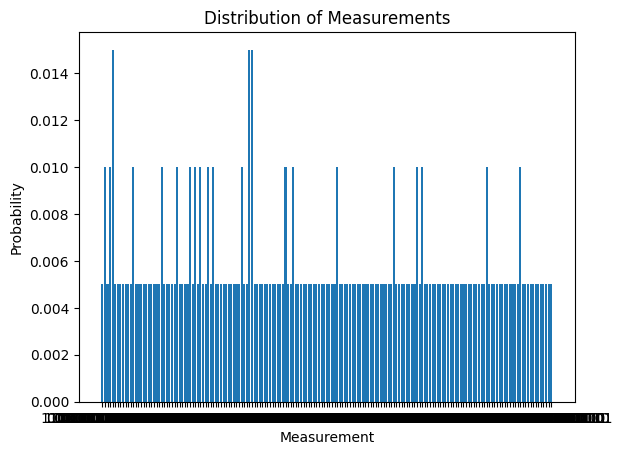

After error correction, the returned logical boolean is: [0, 1]


In [4]:
p=0.25 #Probability input
boolean_input = [0, 1]

steane_code = steane_code_error_correction(p, boolean_input)
distribution, solution = decode_Steane_circuit(steane_code, 2)
print(distribution)

plt.bar(distribution.keys(), distribution.values())
plt.xlabel('Measurement')
plt.ylabel('Probability')
plt.title('Distribution of Measurements')
plt.show()


no_spaces = []

for i in range(len(solution)):
  if solution[i] != ' ':
    no_spaces.append(solution[i])

solution = no_spaces

n = 2
final = []
for i in range(n):
  num = 0
  num = int(solution[7*(n-1-i)]) ^ int(solution[7*(n-1-i)+2]) ^ int(solution[7*(n-1-i)+4]) ^ int(solution[7*(n-1-i) + 6])
  final.append(num)

print(f'After error correction, the returned logical boolean is: {final}')

{'01011100011101': 0.005, '00000001100010': 0.005, '00010010000000': 0.005, '00010010100101': 0.01, '01100111011010': 0.005, '11101001100010': 0.005, '00010110000000': 0.005, '10100011010001': 0.005, '01001111111111': 0.005, '01110001001100': 0.005, '10110001101001': 0.01, '10011101101001': 0.01, '00010011111111': 0.005, '10110000100101': 0.01, '11010010101110': 0.005, '10100110110011': 0.01, '00010010001011': 0.005, '00101100011101': 0.005, '00000000001011': 0.005, '00111110111000': 0.01, '01001110011101': 0.005, '00101001111111': 0.005, '01001010110011': 0.005, '10001111001100': 0.005, '10011000101110': 0.01, '01011100001011': 0.015, '11111110011101': 0.005, '00111010010110': 0.005, '11111111110100': 0.005, '10110100110011': 0.005, '01100011001100': 0.005, '01100010111000': 0.005, '10100111010001': 0.005, '00111110100101': 0.005, '11010111000111': 0.01, '01011101011010': 0.005, '11010011001100': 0.01, '00000001011010': 0.005, '00000100100101': 0.005, '10001010010110': 0.005, '0100101

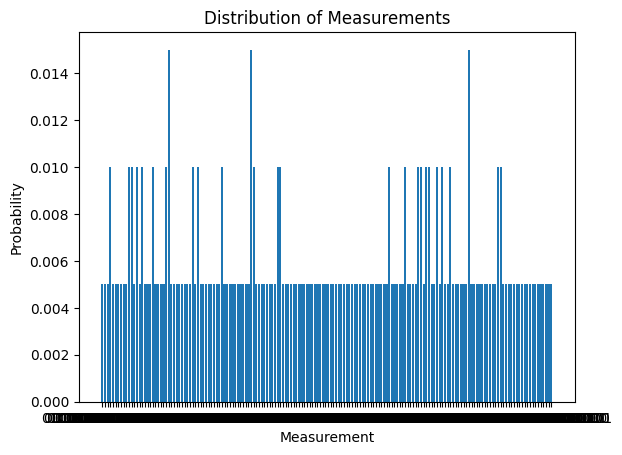

After error correction, the returned logical boolean is: [1, 1]


In [5]:
p=0.05 #Probability input
boolean_input = [0, 1]

steane_code = steane_code_error_correction(p, boolean_input)
distribution, solution = decode_Steane_circuit(steane_code, 2)
print(distribution)

plt.bar(distribution.keys(), distribution.values())
plt.xlabel('Measurement')
plt.ylabel('Probability')
plt.title('Distribution of Measurements')
plt.show()


no_spaces = []

for i in range(len(solution)):
  if solution[i] != ' ':
    no_spaces.append(solution[i])

solution = no_spaces

n = 2
final = []
for i in range(n):
  num = 0
  num = int(solution[7*(n-1-i)]) ^ int(solution[7*(n-1-i)+2]) ^ int(solution[7*(n-1-i)+4]) ^ int(solution[7*(n-1-i) + 6])
  final.append(num)

print(f'After error correction, the returned logical boolean is: {final}')

{'010111000101101011010': 0.005, '000101110110101011010': 0.005, '001110100010011010001': 0.005, '101100011000001110100': 0.005, '010010101001011010001': 0.005, '101101001100010111000': 0.005, '001011001110001001100': 0.005, '110000010100011000111': 0.005, '110101110001110001011': 0.005, '000101100000001010001': 0.005, '111010001100110111000': 0.005, '000001011101000001011': 0.005, '011101001110100100101': 0.005, '110000011111110101110': 0.005, '001110101110000001011': 0.005, '001011010011100000000': 0.005, '011101010001011101001': 0.005, '000100100010110111000': 0.005, '011001110110100011101': 0.005, '111010001110100001011': 0.005, '110101100010111101001': 0.005, '001010001001010110011': 0.005, '100111000111111001100': 0.005, '111111110011001100010': 0.005, '100010110011001100010': 0.005, '111110111111011000111': 0.005, '111010010110000001011': 0.005, '000100110001010010110': 0.005, '111110101110100111000': 0.005, '100111010110001010001': 0.005, '110101101110001010001': 0.005, '010010

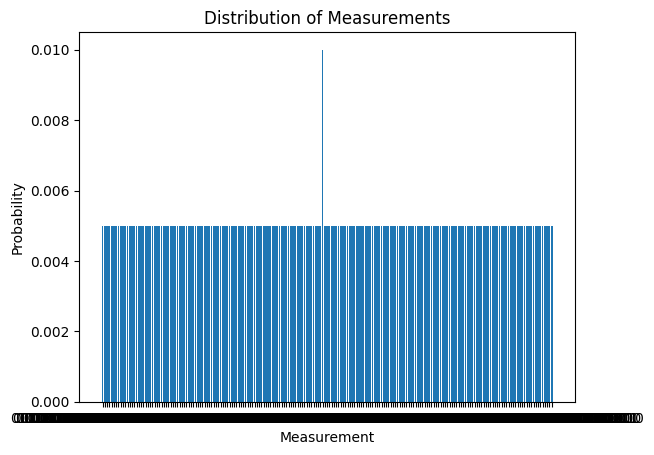

After error correction, the returned logical boolean is: [0, 0, 1]


In [6]:
p=0.5 #Probability input
boolean_input = [0, 0, 0]

steane_code = steane_code_error_correction(p, boolean_input)
distribution, solution = decode_Steane_circuit(steane_code, 3)
print(distribution)

plt.bar(distribution.keys(), distribution.values())
plt.xlabel('Measurement')
plt.ylabel('Probability')
plt.title('Distribution of Measurements')
plt.show()


no_spaces = []

for i in range(len(solution)):
  if solution[i] != ' ':
    no_spaces.append(solution[i])

solution = no_spaces

n = 3
final = []
for i in range(n):
  num = 0
  num = int(solution[7*(n-1-i)]) ^ int(solution[7*(n-1-i)+2]) ^ int(solution[7*(n-1-i)+4]) ^ int(solution[7*(n-1-i) + 6])
  final.append(num)

print(f'After error correction, the returned logical boolean is: {final}')

{'101100001001011000111': 0.005, '001110110001010011101': 0.005, '000100110001110010110': 0.005, '000001010001111010001': 0.005, '001010011010110111000': 0.005, '001111111101100110011': 0.005, '011000101100010011101': 0.005, '000000011010110000000': 0.005, '101000110100111101001': 0.005, '111011000101100010110': 0.005, '110001001011001110100': 0.005, '111010011111111010001': 0.005, '100110010110001010001': 0.005, '011001111000000011101': 0.005, '010110001100011101001': 0.005, '011000101100111100010': 0.005, '111111111010110110011': 0.005, '010010111111111000111': 0.005, '011101010011101110100': 0.005, '100110000010111111111': 0.005, '101000110011100010110': 0.005, '001011010011100101110': 0.005, '111110100000000110011': 0.005, '100110011010011010001': 0.005, '110101100101001111111': 0.005, '101001101110001000111': 0.005, '110101100101001011010': 0.005, '011000101110001001100': 0.005, '011100010001111001100': 0.005, '111011010011001110100': 0.005, '000001011010111110100': 0.005, '010111

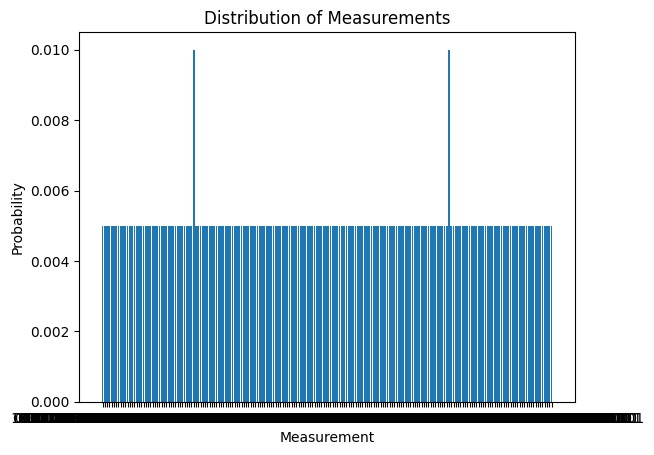

After error correction, the returned logical boolean is: [1, 0, 0]


In [7]:
p=0.005 #Probability input
boolean_input = [0, 0, 0]

steane_code = steane_code_error_correction(p, boolean_input)
distribution, solution = decode_Steane_circuit(steane_code, 3)
print(distribution)

plt.bar(distribution.keys(), distribution.values())
plt.xlabel('Measurement')
plt.ylabel('Probability')
plt.title('Distribution of Measurements')
plt.show()


no_spaces = []

for i in range(len(solution)):
  if solution[i] != ' ':
    no_spaces.append(solution[i])

solution = no_spaces

n = 3
final = []
for i in range(n):
  num = 0
  num = int(solution[7*(n-1-i)]) ^ int(solution[7*(n-1-i)+2]) ^ int(solution[7*(n-1-i)+4]) ^ int(solution[7*(n-1-i) + 6])
  final.append(num)

print(f'After error correction, the returned logical boolean is: {final}')